In [13]:
import tensorflow as tf
import cv2 as cv

print('tf: '+tf.__version__)
print('cv: '+cv.__version__)

tf: 2.3.0
cv: 4.0.1


Function that plays the videos within a directory

In [14]:
def play_videos(directory):
    
    for video_name in os.listdir(directory):
    # try:
            cap=cv.VideoCapture(directory+video_name)
            while cap.isOpened():
                ret, frame=cap.read()
                if not ret:
                    print("Can't receive frame (stream end?). Exiting...")
                    break
                cv.imshow('frame',frame)
                if cv.waitKey(1)==ord('q'):
                    break

            cap.release()
            cv.destroyAllWindows()
#play_videos('../hmdb51_org/fall_floor/')

We get the labels of the HMDB51 dataset

In [15]:
labels = os.listdir('../hmdb51_org')

We get the name of the first train and test videos.

In [16]:
import re

splits_files= os.listdir('../test_train_splits')
train_split1=[]
test_split1=[]
r = re.compile('1\.txt$')
first_split_files=list(filter(r.search,splits_files))

for file in first_split_files:
    
    f=open('../test_train_splits/'+file,'r')
    for line in f:
        if(re.search('1 $',line)):
            train_split1.append(line.split(' ',1)[0])
        elif(re.search('2 $',line)):
            test_split1.append(line)

    f.close()

Instantiate the Xception architecture and freeze the model

In [17]:
pretrained_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(240,240,3),
    classifier_activation='softmax'
)

pretrained_model.trainable=False

We create the model that is going to sit on top of the pretrained model

In [18]:
inputs = tf.keras.Input(shape=(240,240,3))

x = pretrained_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(len(labels),activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

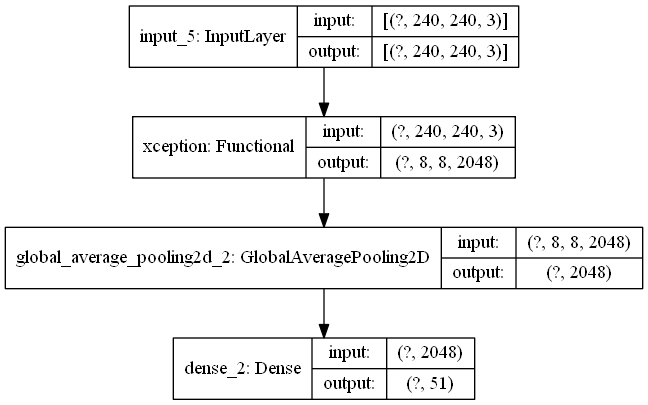

In [19]:
tf.keras.utils.plot_model(model, "modelo_tfg.png", show_shapes=True)